<a href="https://colab.research.google.com/github/Syed-Raza-Ali/Agentic_chatbot/blob/main/Agentic_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Agentic AI Chatbot Project**

Autonomous systems are designed to carry out tasks, make decisions, and engage with users with little to no human input. Using advanced AI, they grasp context, learn from their interactions, and deliver responses tailored to each user

**Install the required packages**

In [ ]:
# install the required packages
%%capture --no-stderr
%pip install -U langchain_core langchain_google_genai tavily-python langchain_community

In [ ]:
%%capture --no-stderr
%pip install -U langgraph

In [ ]:
# Upgrade LangChain and langchain_core (if needed)
%%capture --no-stderr
%pip install --upgrade langchain langchain_core langchain==0.0.256 langchain_core==0.0.154
%pip install --force-reinstall langchain

**CREATE VARIABLES FOR API KEYS**

In [ ]:
# API KEYS VARIABLES

from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

**Use** `ChatGoogleGenerativeAI` **For LLM**

- NOTE: This library using because langGraph dont have any chat model LLM thats why we use google gemini `gemini-1.5-flash` chat model.


In [ ]:
# LLM
from langchain_google_genai import  ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    api_key = GEMINI_API_KEY,
    temperature = 0
)

In [ ]:
# LLM TESTING - (SUCCESFULL)

result = llm.invoke("hi")
result

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-54ec01f4-3b64-4d2a-ac9b-8a542e507f3e-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

###**Creating a State Graph for an Agentic Chatbot with LangGraph**

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Create a StateGraph instance with the State type
graph_builder = StateGraph(State)

# create node of chatbot
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# NOTE
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

# Check if the node already exists before adding it
if "chatbot" not in graph_builder.nodes:
    graph_builder.add_node("chatbot", chatbot)
else:
    print("Node 'chatbot' already present.")

# # Adding nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()



**Explanation**:

**1. Imports**:
```
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

```

- `Annotated`: Allows the annotation of a type with additional information, used here to link the `messages` field to the `add_messages` function.
- `TypedDict`: Enables defining dictionary-like objects with specific key-value types.
- `StateGraph`: A core class from LangGraph for constructing and managing state-based directed graphs.
- `START`, `END`: Special nodes in the graph representing the beginning and end of a state sequence.
- `add_messages`: A utility function to append new messages to an existing list of messages in the state.


```
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

- `State`: Represents the `state` as a dictionary with messages, managed by add_messages.


```
graph_builder = StateGraph(State)
```
- Initializes a new graph for managing states.


```
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

```
- `chatbot` Function: Processes the chatbot state and returns a response using an LLM.


```
if "chatbot" not in graph_builder.nodes:
    graph_builder.add_node("chatbot", chatbot)
else:
    print("Node 'chatbot' already present.")

```
- Ensures the `chatbot` node is added only once.

```
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
```
- Defines the flow from `START` through `chatbot` to `END`.


```
graph = graph_builder.compile()
```
- Finalizes and compiles the graph for execution.

###**Displaying the Graph with IPython and Mermaid**

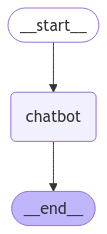

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


**Explanation :**
```
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

```

- `Image` and `display`:
  - Imports Image and `display` from IPython to `display` images in the notebook.
- `graph.get_graph().draw_mermaid_png():`
  - Retrieves the graph object and uses Mermaid syntax to draw a PNG image of the graph.
  - Requires additional dependencies for full functionality (Mermaid support), which might need to be installed separately.
- `try-except` block:
  - Attempts to display the graph, but if any error occurs (such as missing dependencies), it catches the exception and gracefully handles it without crashing the notebook.


**Summary:**

- This code snippet integrates a visual representation of the graph into the IPython notebook, making it easier to understand the flow of states and the connections between nodes.

###**Streaming Events and Displaying User Messages**

In [ ]:
# Loop through each event in the stream of events from the graph
for event in graph.stream({"messages": [("user", "Hi from User")]}):
    # Print the latest message content from the user
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hi there, User!  How can I help you today?



**Explanation:**

- `graph.stream({"messages": [("user", "Hi from User")]}):`

  - Initiates a stream of events for the graph with an initial user message ("Hi from User").
The graph processes each event sequentially.

- `for event in graph.stream(...):`

    - Iterates over each event in the stream.
`list(event.values())[0]["messages"][-1].content`: Retrieves the latest message content from the user in the current event.

###**Handling User Input and Streaming Graph Updates**

In [ ]:
def stream_graph_updates(user_input: str):
    # Loop through each event in the stream of events from the graph based on user input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Loop through each value in the event
        for value in event.values():
            # Print the latest message content from the Assistant
            print("Assistant:", value["messages"][-1].content)

# Continuously prompt the user for input
while True:
    try:
        # Get input from the user
        user_input = input("User prompt: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            # Print a goodbye message and break the loop
            print("Bye, Have a good Day!")
            break

        # Call the stream_graph_updates function with the user input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "Tell me the difference between langchain and LangGraph"
        # Print the fallback user input
        print("User prompt: " + user_input)
        # Call the stream_graph_updates function with the fallback user input
        stream_graph_updates(user_input)
        break

User prompt: Hey wassup
Assistant: Not much, just hanging out and ready to answer your questions!  What's up with you?

User prompt: Q
Bye, Have a good Day!


**Explanation:**

- `stream_graph_updates(user_input: str):`

    - This function takes a user_input and streams the graph updates based on it.
    - The `graph.stream(...)` function initiates a stream of events with the given user input.
    - It iterates over each event and prints the latest message content from the Assistant.

- `while True::`

    - A loop that continues until the user decides to quit.

- **User Input Handling:**

    - Prompts the user for input.
    - Checks if the user wishes to exit (with options like "quit", "exit", or "q").
    - If the input is not a termination command, it calls `stream_graph_updates()` with the user's input.
    - If there's an issue with input (like in environments where `input()` is not available), it falls back to a predefined user input.


##**LLM with Tools binding**

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

####**Set Tavily API Key in os**

In [ ]:
import os

os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

###**Building and Compiling a State Graph with Tools Integration**

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph
graph = graph_builder.compile()

**Summary:**

This code integrates tools into the agentic chatbot state graph using LangGraph. Key components include:

- Defining a `State` with messages.
- Integrating a search tool `(TavilySearchResults)` and binding it to the LLM.
- Adding a `chatbot` node to handle messages.
- Including a tools node for tool operations.
- Setting up conditional edges based on tool usage.
- Compiling the graph for execution.

###**Displaying the Graph Structure with Mermaid Syntax**

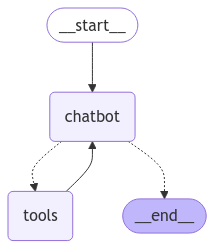

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Summary:**

This code provides a visual representation of the chatbot's state graph using Mermaid syntax. It is an effective way to quickly understand the graph structure, including nodes, edges, and connections between the chatbot and tools.








###**Interactive Chatbot with Tavily Search Integration and Chat History Logging**





In [44]:
from google.colab import userdata
from langchain_community.tools.tavily_search import TavilySearchResults

# Retrieve Tavily API key from Google Colab environment
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

# Initialize Tavily search tool
tavily_search = TavilySearchResults(max_results=3)

# Maintain chat history
chat_history = []

def stream_graph_updates(user_input):
    """
    A placeholder function for processing graph updates.
    Replace with your actual implementation.
    """
    print(f"Processing graph updates for: {user_input}")

# Main chatbot loop
while True:
    try:
        # Prompt the user for input
        user_input = input("User prompt: ").strip()

        # Exit condition
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Bye! Have a great day!")
            break

        # Handle empty input
        if not user_input:
            print("No prompt found. Please type something.")
            continue

        # Add user input to chat history
        chat_history.append({"role": "user", "content": user_input})

        # Call the placeholder function (replace as needed)
        try:
            stream_graph_updates(user_input)
        except NameError:
            # Handle missing function gracefully
            print("stream_graph_updates is not implemented. Skipping.")

        # Perform a Tavily search if the function is not implemented
        search_docs = tavily_search.invoke(user_input)

        # Add Tavily response to chat history
        chat_history.append({"role": "assistant", "content": str(search_docs)})

        # Display results from Tavily search
        print("Search Results:")
        for i, doc in enumerate(search_docs, start=1):
            print(f"\nResult {i}:")
            print(f"Here is the {i} documentaion from web search you can get your answer from here:")
            print(f"Content: {doc.get('content', 'N/A')}")
            print(f"URL: {doc.get('url', 'N/A')}")

    except Exception as e:
        print(f"An error occurred: {e}")
        break

# Print chat history at the end of the session
print("\nChat History:")
for message in chat_history:
    role = message["role"]
    content = message["content"]
    print(f"{role.capitalize()}: {content}")


User prompt: what is the networth of  elon musk
Processing graph updates for: what is the networth of  elon musk
Search Results:

Result 1:
Here is the 1 documentaion from web search you can get your answer from here:
Content: Elon Musk in 2023. Elon Musk is the wealthiest person in the world, with an estimated net worth of US$369 billion as of December 2024, according to the Bloomberg Billionaires Index, and $400 billion according to Forbes, primarily from his ownership stakes in Tesla, Inc. and SpaceX. [1] [2] [3] In November 2021, he became the first person in the world to have a net worth above $300 billion, and
URL: https://en.wikipedia.org/wiki/Wealth_of_Elon_Musk

Result 2:
Here is the 2 documentaion from web search you can get your answer from here:
Content: Elon Musk Net Worth Tops $400 Billion, a Historic First - Bloomberg Bloomberg Tech At Bloomberg Bloomberg London Bloomberg Beta Bloomberg Terminal Industry Products Bloomberg Law Bloomberg Tax Bloomberg Government Bloomberg

**Summary:**

This code implements an interactive chatbot that leverages Tavily Search for retrieving structured search results. The chatbot features:

- User Interaction: Continuously prompts the user for input and allows exiting with keywords like "quit," "exit," or "q."
- Tavily Search Integration: Performs searches using the Tavily Search API and displays structured results (content, URL).
- Chat History Logging: Maintains a log of user inputs and the assistant's responses, which is displayed at the end of the session.
- Error Handling: Gracefully manages empty inputs, unimplemented functions, and runtime exceptions.
- Also have real time information to get current data using browsing search

###**Adding Memory to the Chatbot in the State Graph**

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START # , END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# (Part 3: Adding Memory to the Chatbot)
# Add memory saver for checkpointing
memory = MemorySaver()

#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Integrate LLM with bind_tools for web search
llm_with_tools = llm.bind_tools(tools)

# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph with memory checkpointing
graph = graph_builder.compile(checkpointer=MemorySaver())

**Summary:**

This updated code integrates memory checkpointing into the chatbot’s state graph, enabling the preservation of context across interactions. It also sets up a chatbot with tools for web search and manages conditional tool usage. The graph is compiled with memory to ensure continuity in conversations.

###**Displaying the Graph Structure with Mermaid Syntax**

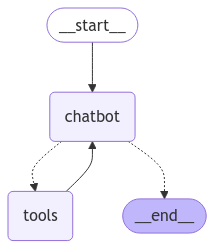

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Summary:**

This code provides a visual representation of the chatbot's state graph using Mermaid syntax. It is an effective way to quickly understand the graph structure, including nodes, edges, and connections between the chatbot and tools.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Summary:


The configuration dictionary `config` is setting up a configuration object for a specific thread or conversation with an identifier of `"1"` under the `configurable` key.

###**Streaming Chatbot Events with Configuration**

In [ ]:
user_input = input("UserInput: ")

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()

UserInput: heyo my name is Raza
================================ Human Message =================================

heyo my name is Raza
================================== Ai Message ==================================

Heyo Raza!  It's good to see you again.


**Summary:**

This code sets up a streaming mechanism to receive real-time responses from the chatbot based on user input. Each event from the stream is processed individually to display the latest message content, allowing for continuous interaction between the user and the chatbot. The configuration allows for fine-tuning the stream’s behavior based on specific needs.

###**Streaming Events from Chatbot**

In [ ]:
user_input = input("UserInput: ")

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()


UserInput: have you remembder me ?
================================ Human Message =================================

have you remembder me ?
================================== Ai Message ==================================

Yes, I remember you. You are Raza.


**Summary:**

This code snippet captures user input, streams events from the chatbot’s state graph, and iterates over the events to print the latest messages in real-time. The configuration `(config)` allows customization of how the stream operates, making the interaction dynamic and responsive.